<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   restecg   270 non-null    int64  
 7   thalach   270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  ca        270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB
None
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   70    1   4       130   322    0        2      109      0      2.4      2   
1   67    0   3       115   564    0        2      1

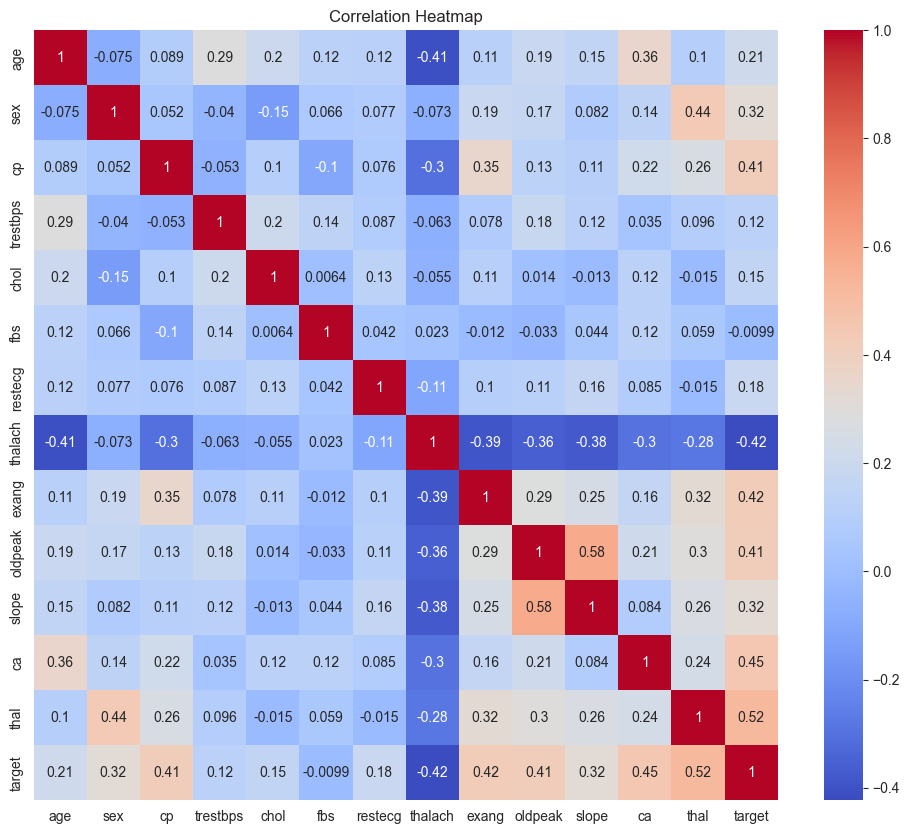

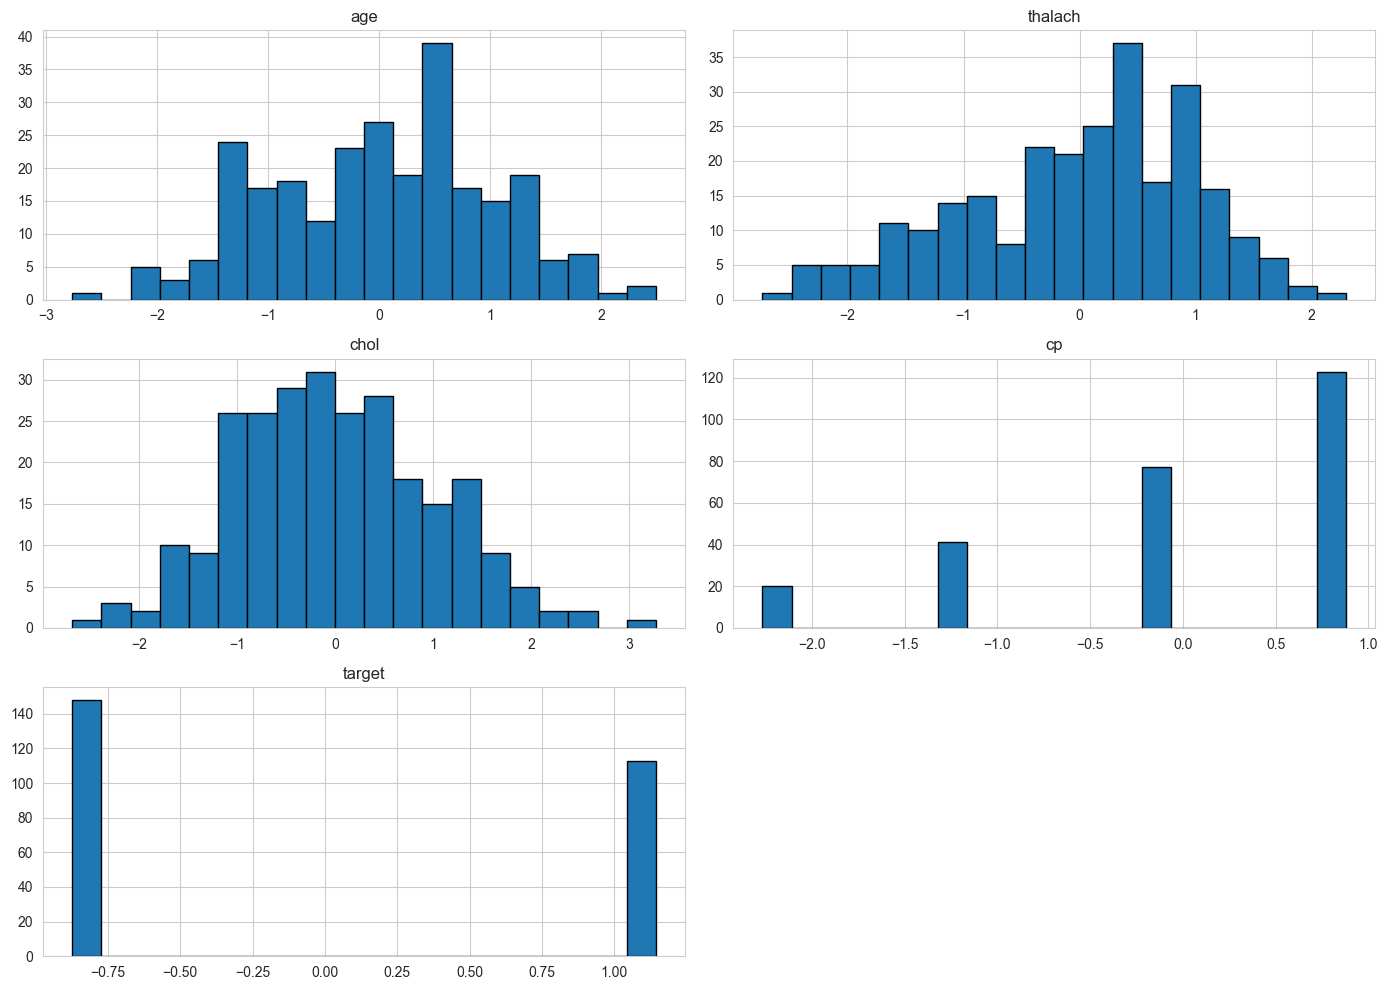

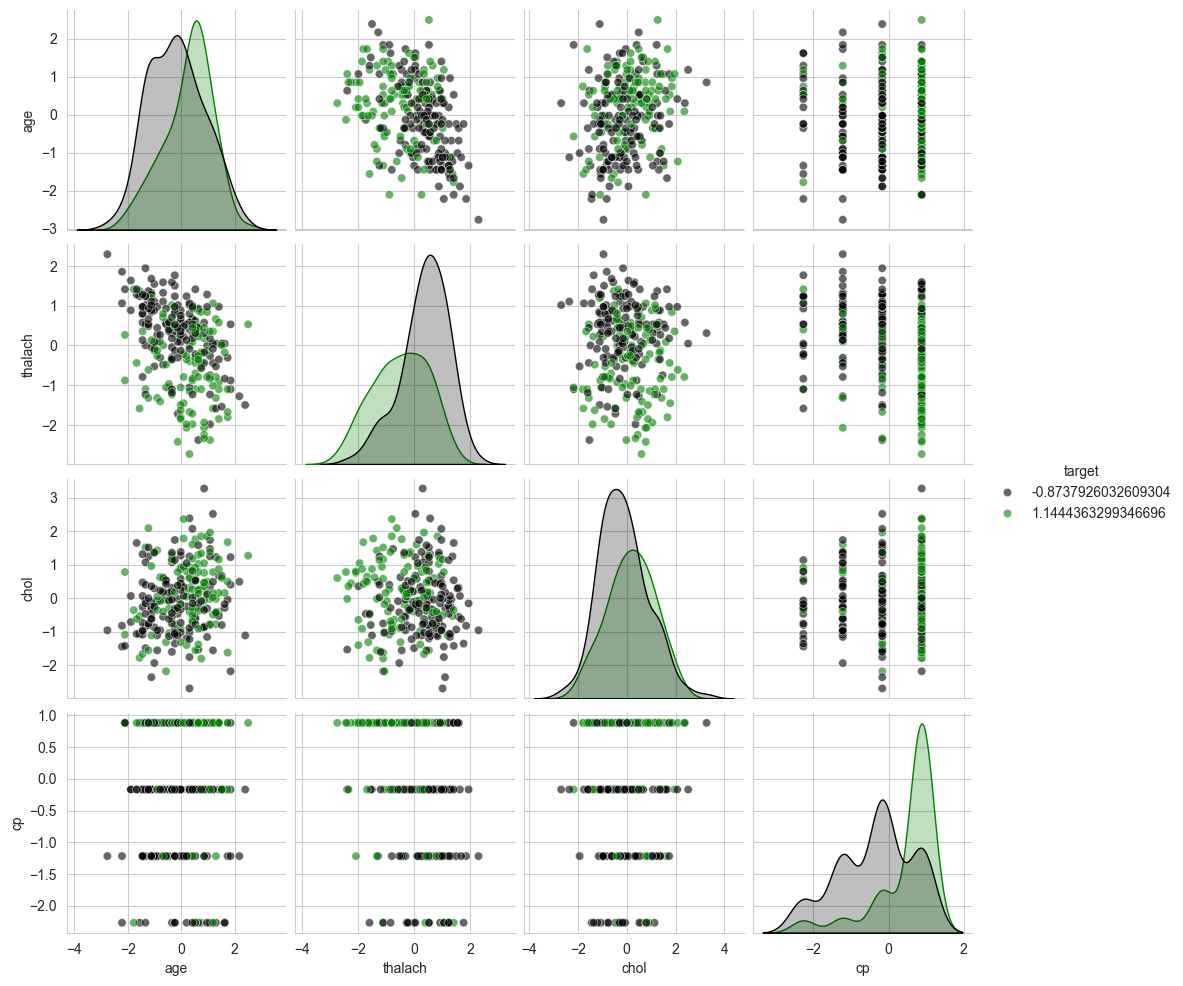

Classes in training set: 2
Classes in test set: 2


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


                          Model  Accuracy Precision    Recall
0           Logistic Regression  0.796178   0.80303  0.736111
1      Random Forest Classifier  0.770701  0.833333     0.625
2  Gradient Boosting Classifier  0.694268  0.722222  0.541667
3                       XGBoost  0.751592  0.789474     0.625
4                 TensorFlow NN  0.821656       N/A       N/A


In [32]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv('data.csv')  # Ensure the correct path to your CSV file

# Display basic information and the first few rows of the dataframe
print(df.info())
print(df.head())

### Handling Missing Values ###
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

### Identifying and Treating Outliers ###
z_scores = np.abs(stats.zscore(df.select_dtypes(include=['float64', 'int64'])))
df = df[(z_scores < 3).all(axis=1)]

### Encoding Categorical Variables ###
df = pd.get_dummies(df, drop_first=True)

### Normalizing Numerical Columns ###
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Visualizing distributions and relationships ###
# Correlation Heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Histograms and Pairwise scatter plots
selected_features = ['age', 'thalach', 'chol', 'cp', 'target']
df[selected_features].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

black_green_palette = ['black', 'green']
sns.pairplot(df[selected_features], hue='target', palette=black_green_palette, plot_kws={'alpha': 0.6})
plt.show()

### Normalizing Numerical Columns ###
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Verify and Adjust Target Variable for Binary Classification ###
df['target'] = (df['target'] > 0.5).astype(int)
if df['target'].nunique() < 2:
    raise ValueError("Target variable must have at least 2 classes.")

### Split the Data ###
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

# Check the balance of the target variable
print(f"Classes in training set: {y_train.nunique()}")
print(f"Classes in test set: {y_test.nunique()}")

if y_train.nunique() < 2 or y_test.nunique() < 2:
    raise ValueError("Both training and test sets need at least 2 classes.")

### Define and Train Models ###
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    return accuracy, precision, recall

results = []
for name, model in models.items():
    accuracy, precision, recall = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append({"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall})

### TensorFlow Neural Network for Binary Classification ###
def create_nn():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn = create_nn()
nn.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
nn_loss, nn_accuracy = nn.evaluate(X_test, y_test, verbose=0)

results.append({
    "Model": "TensorFlow NN",
    "Accuracy": nn_accuracy,
    "Precision": "N/A",
    "Recall": "N/A"
})

### Summary of Model Performances ###
results_df = pd.DataFrame(results)
print(results_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   restecg   270 non-null    int64  
 7   thalach   270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  ca        270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB
None
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   70    1   4       130   322    0        2      109      0      2.4      2   
1   67    0   3       115   564    0        2      1

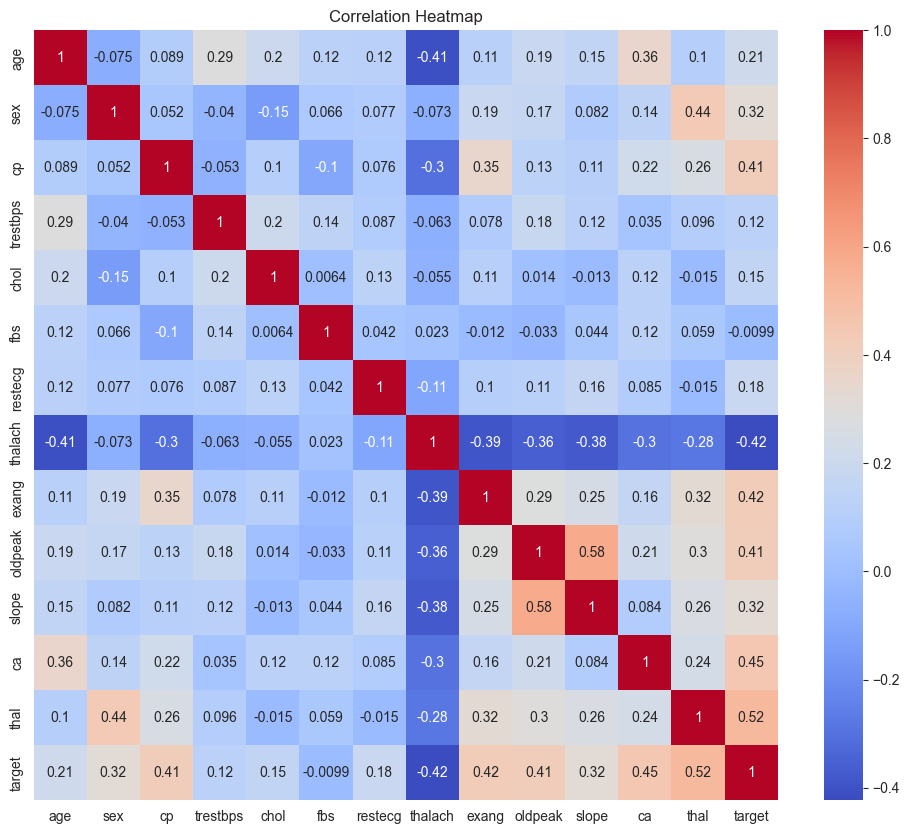

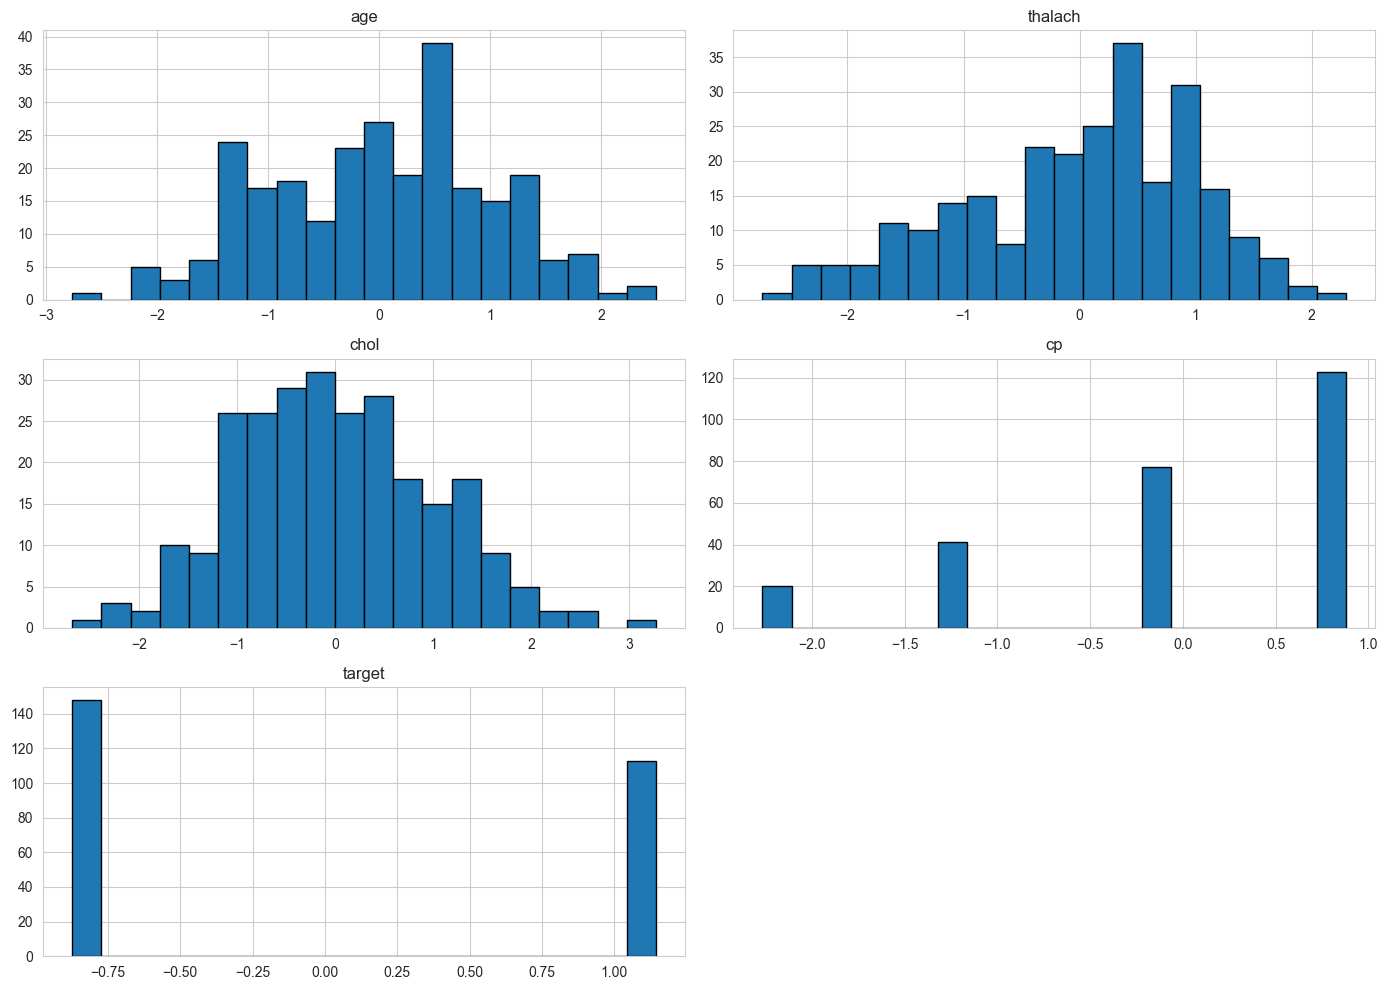

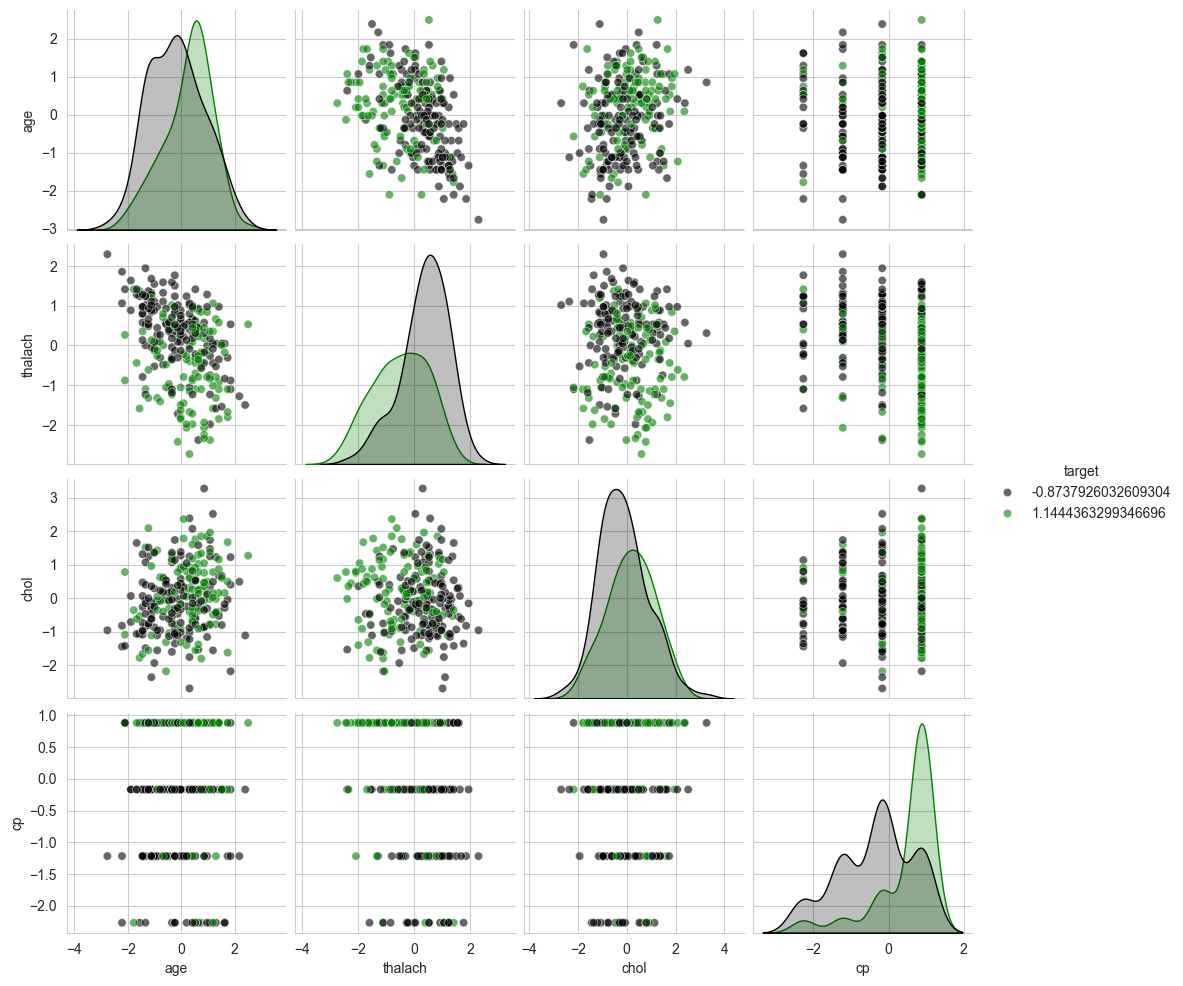

Epoch 1/10


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6549 - loss: 0.6643 
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8606 - loss: 0.4415
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8610 - loss: 0.3709  
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8381 - loss: 0.3817  
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8945 - loss: 0.3068
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8606 - loss: 0.3434  
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8695 - loss: 0.3080  
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.3236  
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9039 - loss: 0.2661  
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8249 - loss: 0.3259  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8152 - loss: 0.4964  
                          Model  Accuracy Precision    Recall
0           Logistic

In [36]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv('data.csv')  # Ensure the correct path to your CSV file

# Display basic information and the first few rows of the dataframe
print(df.info())
print(df.head())

### Handling Missing Values ###
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

### Identifying and Treating Outliers ###
z_scores = np.abs(stats.zscore(df.select_dtypes(include=['float64', 'int64'])))
df = df[(z_scores < 3).all(axis=1)]

### Encoding Categorical Variables ###
df = pd.get_dummies(df, drop_first=True)

### Normalizing Numerical Columns ###
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Visualizing distributions and relationships ###
# Correlation Heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Histograms and Pairwise scatter plots
selected_features = ['age', 'thalach', 'chol', 'cp', 'target']  # Ensure these features exist in your dataset
df[selected_features].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

black_green_palette = ['black', 'green']
sns.pairplot(df[selected_features], hue='target', palette=black_green_palette, plot_kws={'alpha': 0.6})
plt.show()

### Verify and Adjust Target Variable for Binary Classification ###
df['target'] = (df['target'] > 0.5).astype(int)
if df['target'].nunique() < 2:
    raise ValueError("Target variable must have at least 2 classes.")

### Split the Data ###
X = df.drop('target', axis=1)  # Adjust 'target' to your actual target column name
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature Selection ###
select = SelectFromModel(RandomForestClassifier(n_estimators=100))
X_train_transformed = select.fit_transform(X_train, y_train)
X_test_transformed = select.transform(X_test)

### Define and Train Models ###
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM Classifier": SVC(probability=True),
    "Gaussian Naive Bayes": GaussianNB()
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    return accuracy, precision, recall

results = []
for name, model in models.items():
    accuracy, precision, recall = evaluate_model(model, X_train_transformed, y_train, X_test_transformed, y_test)
    results.append({"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall})

### TensorFlow Neural Network for Binary Classification ###
def create_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn = create_nn(X_train_transformed.shape[1])
history = nn.fit(X_train_transformed, y_train, epochs=10, batch_size=10, verbose=1)
nn_loss, nn_accuracy = nn.evaluate(X_test_transformed, y_test, verbose=1)

results.append({
    "Model": "TensorFlow NN",
    "Accuracy": nn_accuracy,
    "Precision": "N/A",
    "Recall": "N/A"
})

### Summary of Model Performances ###
results_df = pd.DataFrame(results)
print(results_df)